## Section 1

**1) Below implement k-means algorithm from scratch (without any external libraries).**

56.784168212739644
356.26447445280553
87.27990222106557
16.98603634988537
18.961127129953823
6.852822923094191
11.78892500473345
5.044680192867106
2.003594622472315
0.710268425795193
1.889769422986607
0.7456876460704867


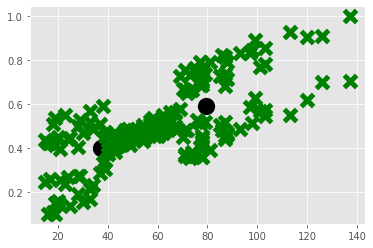

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import style
import pandas as pd
style.use('ggplot')



data=pd.read_csv('./dataset.csv')

X=np.array(data[data.columns[data.columns.isin(['Annual Income (k$)','Buy Likely'])]])

class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

model = K_Means()
model.fit(X)

for centroid in model.centroids:
    plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

for classification in model.classifications:
    color = 'green'
    for featureset in model.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
        
plt.show()

**2) Is feature scaling required for the K-means Algorithm? Explain why or why not.**

Yes.
Feature scaling is required before features are supplied into clustering methods such as K-means.
Because Euclidean Distance is used to build cohorts in clustering algorithms, it's a good idea to scale variables like heights in metres and weights  before computing the distance. 

 **3) How are centriods use in K-means? What are some alterenatives that you could use?**

Clustering with k-means is a basic yet effective method. Traditionally, k data points are picked at random as cluster centres, or centroids, from a given dataset, and all training examples are plotted and assigned to the nearest cluster. After all instances have been assigned to clusters, the centroids, which reflect the mean of each cluster's instances, are recalculated, and these recalculated centroids become the new cluster centres.

All cluster membership is reset at this stage, and all instances of the training set are re-plotted and re-added to the nearest, perhaps re-centered, cluster. This repeated procedure continues until the centroids and their membership remain unchanged, and the clusters are deemed settled.

Because k-means clustering aims to find an optimal set of cluster centres (centroids) and cluster membership based on distance from these centroids through successive iterations, it stands to reason that the more optimal the positioning of these initial centroids, the fewer iterations of the k-means clustering algorithms will be required for convergence. This implies that some strategic thought should be given to the establishment of these initial centroids.

**4) Does centroid initialization make a difference with the K-means Algorithm? Demonstrate using a small example (10 points) by running the algorithm.**

Yes, the centroid initialization affects the ultimate outcomes of the k means method, since inadequate initialization might cause the algorithm to become trapped in an inferior local minimum.

In [1]:
from math import sqrt, floor
import numpy as np


def random(ds, k, random_state=42):
    """
    Create random cluster centroids.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    np.random.seed(random_state)
    centroids = []
    m = np.shape(ds)[0]

    for _ in range(k):
        r = np.random.randint(0, m-1)
        centroids.append(ds[r])

    return np.array(centroids)


def plus_plus(ds, k, random_state=42):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)


def naive_sharding(ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    def _get_mean(sums, step):
        """Vectorizable ufunc for getting means of summed shard columns."""
        return sums/step

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.zeros((k, n))

    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    step = floor(m/k)
    vfunc = np.vectorize(_get_mean)

    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids

 **5) What are the challenges associated with K-means clustering? State at least 3.**

The following are the difficulties that K-Means Clustering faces:

1. If the clusters have varied sizes, densities, or non-spherical geometries, k-Means does not perform well.
2.Must be run for a particular number of iterations or the outcome would be poor.
3.Computer intensive since distances from each centroid to all data points must be computed.
4.It can't handle data with a lot of dimensions.
5.Specify the number of clusters to be created.
6.The outcome is not precisely repeatable since the initial centroids were picked arbitrarily.
7.Shows an out-of-memory error when working with huge datasets.

**6) How to decide the optimal number of K in the K means Algorithm? Describe at least 2 methods.**

The representation of a cluster is the cluster centre.
The needed variation is the squared distance between each point and its cluster centre.
The goal of k-means clustering is to locate these k clusters and their centres while minimising total error.



These are two approaches for locating the mysterious k in k-Means.


These are the methods:


   1. The Elbow Method

    Calculate the Within-Cluster-Sum of Squared Errors (WSS) for various values of k and select the k for which WSS begins to decline earliest.
    This is seen as an elbow in the WSS-versus-k figure. 

   2. The Silhouette Method
 
    In comparison to other clusters, the silhouette value reflects how similar a point is to its own cluster (cohesion) (separation).
    The Silhouette value might be anything between +1 and -1.
    A high value is preferable since it implies that the point has been correctly positioned in the cluster.
    If a large number of points have a negative Silhouette value, it's possible that we've made too many or too few clusters. 


**7) How to perform K means on larger datasets to make it faster?**
**7) Implement 

Data mining and processing might be difficult when dealing with extremely huge datasets.
MapReduce is a sophisticated programming framework that divides a job into several tasks and performs them in a distributed environment, resulting in greatly reduced execution time.
K-Means is a popular clustering approach, and K-Means built on MapReduce provides a sophisticated solution for clustering very big datasets.
However, because to the rising number of iterations as the dataset size and number of clusters grow, the execution time remains a challenge.
This study introduces a novel method for lowering the amount of iterations in the K-Means technique, which may be used to cluster very large datasets. 



centroids = k random sampled points from the dataset.

do:

    Map:
        - Given a point and the set of centroids.
        - Calculate the distance between the point and each centroid.
        - Emit the point and the closest centroid.
        
    Reduce:
        - Given the centroid and the points belonging to its cluster.
        - Calculate the new centroid as the aritmetic mean position of the points.
        - Emit the new centroid.      
    
    prev_centroids = centroids.
    centroids = new_centroids.
    
while prev_centroids - centroids > threshold.  

class MAPPER
    method MAP(file_offset, point)
        min_distance = POSITIVE_INFINITY
        closest_centroid = -1
        for all centroid in list_of_centroids
            distance = distance(centroid, point)
            if (distance < min_distance)
                closest_centroid = index_of(centroid)
                min_distance = distance
        EMIT(closest_centroid, point) 

    class COMBINER
    method COMBINER(centroid_index, list_of_points)
        point_sum.number_of_points = 0
        point_sum = 0
        for all point in list_of_points:
            point_sum += point
            point_sum.number_of_points += 1
        EMIT(centroid_index, point_sum)    

class REDUCER
    method REDUCER(centroid_index, list_of_point_sums)
        number_of_points = partial_sum.number_of_points
        point_sum = 0
        for all partial_sum in list_of_partial_sums:
            point_sum += partial_sum
            point_sum.number_of_points += partial_sum.number_of_points
        centroid_value = point_sum / point_sum.number_of_points
        EMIT(centroid_index, centroid_value)



Faiss is a library for searching for and grouping similarity quickly. It was developed by Facebook AI Research (FAIR), and it makes clever use of vectors as well as parallelism across CPU cores to speed up computations. Furthermore, it has a GPU component for significantly faster performance on larger datasets.





In [5]:
!pip3 install faiss-cpu 

In [6]:
import numpy as np
import time

from sklearn.cluster import KMeans
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(len(x_train), -1).astype(float) / 255.
x_test = x_test.reshape(len(x_test), -1).astype(float) / 255.

clf = KMeans(n_clusters=10)

s = time.time()
clf.fit(x_train)
e = time.time()
print("Training time = {}".format(e - s))


s = time.time()
clf.predict(x_test)
e = time.time()
print("Prediction time = {}".format((e - s) / len(y_test)))

Training time = 53.669334411621094
Prediction time = 5.639386177062989e-06


## Section 2 
### Import the dataset and answer the following questions
**Note: Please write observations in detail**


**Task 1) Perform statistical analysis on the dataset(check the distribution for both numerical and categorcial 
columns(pairplots or any other plots) and correlation among the numerical features)**

In [7]:
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import style
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

data=pd.read_csv('./dataset.csv')

print(data.head())
print(data.shape)
print(data.describe())



   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Buy Likely  
0       0.245  
1       0.436  
2       0.100  
3       0.423  
4       0.259  
(200, 6)
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)  \
count  200.000000  200.000000          200.000000              200.000000   
mean   100.500000   38.850000           60.560000               50.200000   
std     57.879185   13.969007           26.264721               25.823522   
min      1.000000   18.000000           15.000000                1.000000   
25%     50.750000   28.750000           41.500000               3

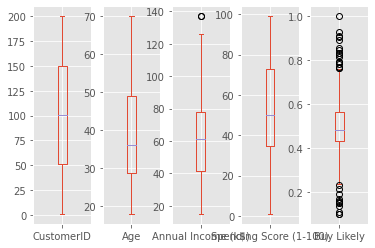

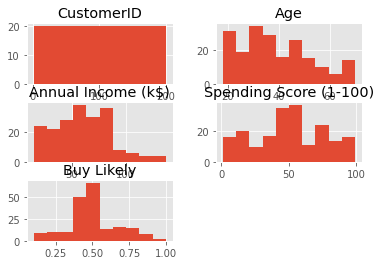

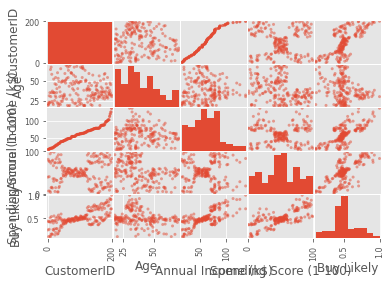

Age                      -0.327227
Annual Income (k$)        0.009903
Spending Score (1-100)    1.000000
Buy Likely                0.704556
Name: Spending Score (1-100), dtype: float64

In [8]:
data.plot(kind='box',subplots=True)
pyplot.show()
data.hist()
pyplot.show()
scatter_matrix(data)
pyplot.show()

data[data.columns[1:]].corr()['Spending Score (1-100)'][:]

Take all the numerical columns and fit K-means model on it**Task 2)  (No need to perfrom one-hot encoding/label encoding for 
categorical features)**

In [9]:
import pandas as pd
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3, random_state= 42)
X=data[data.columns[data.columns.isin(['CustomerID', 'Age', 'Annual Income (k$)','Spending Score (1-100)', 'Buy Likely'])]]
y = kmeans_model.fit_predict(X)

data['Cluster'] = y
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Buy Likely  Cluster  
0       0.245        2  
1       0.436        2  
2       0.100        2  
3       0.423        2  
4       0.259        2  


**Task 3) Find the optimal K value and show a plot that it is optimal. Decribe what you did and why.**

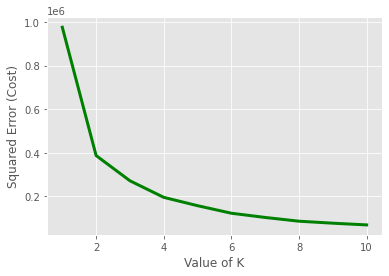

In [10]:
cost =[]
for i in range(1, 11):
    KM = KMeans(n_clusters = i, max_iter = 500)
    KM.fit(data[data.columns[data.columns.isin(['CustomerID', 'Age', 'Annual Income (k$)','Spending Score (1-100)', 'Buy Likely'])]])
     
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)    
 
# plot the cost against K values
plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot

The elbow approach is a common way for determining the ideal value of K when using the K-Means Clustering Algorithm.
The essential concept behind this approach is that it graphs various cost values as k changes.
There will be fewer items in the cluster as the value of K grows.
As a result, the average distortion will be reduced.
The fewer the elements, the closer you are to the centroid.
As a result, the elbow is the site where this distortion decreases the greatest. 

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X=data[data.columns[data.columns.isin(['CustomerID', 'Age', 'Annual Income (k$)','Spending Score (1-100)', 'Buy Likely'])]]
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 62.3631978249332
2 : 41.57028204941997
3 : 34.657805760225976
4 : 28.904096635835884
5 : 25.720792102848176
6 : 22.837065019018446
7 : 20.971770230603592
8 : 19.535778396507
9 : 18.483735646411258


**Task 4) Calculate the silhouette score and compare the optimal K value you found in Task 3 . Are they same or different? Explain why or why not**

For n_clusters = 2 The average silhouette_score is : 0.47934517492490947
For n_clusters = 3 The average silhouette_score is : 0.37674298168980613
For n_clusters = 4 The average silhouette_score is : 0.4225396806554667
For n_clusters = 5 The average silhouette_score is : 0.4232001532867182
For n_clusters = 6 The average silhouette_score is : 0.4096556240812718


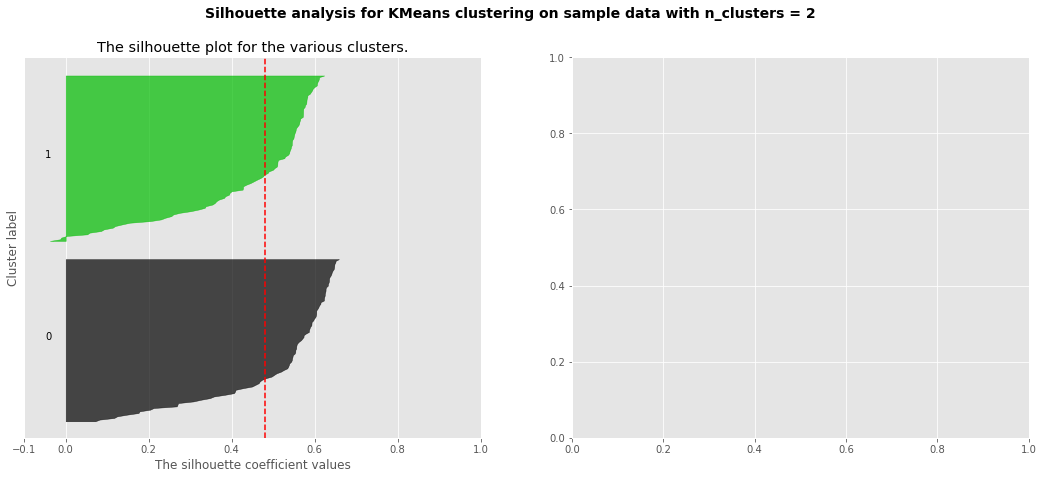

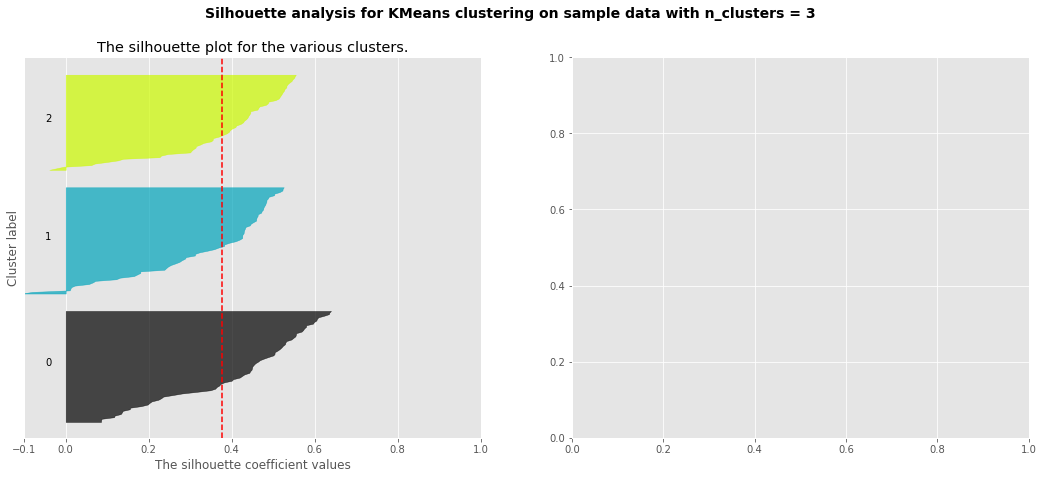

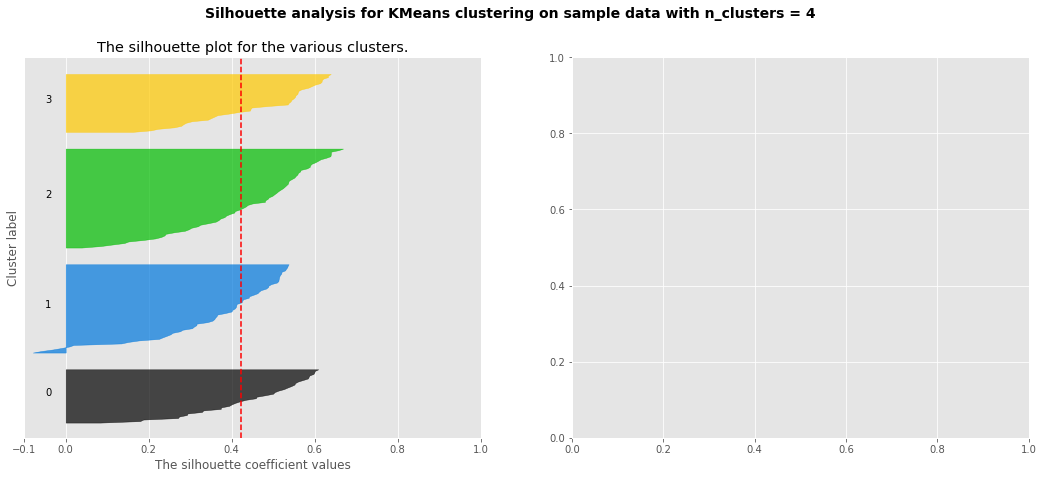

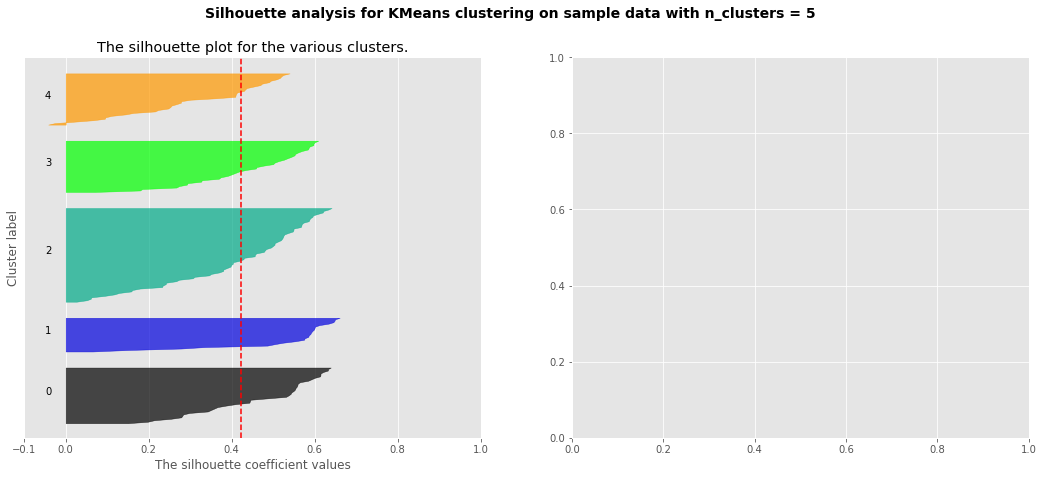

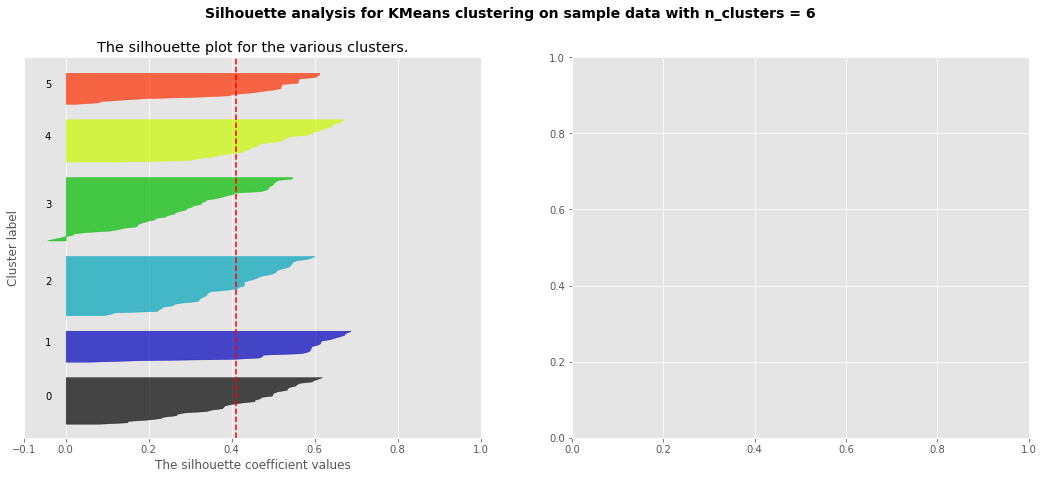

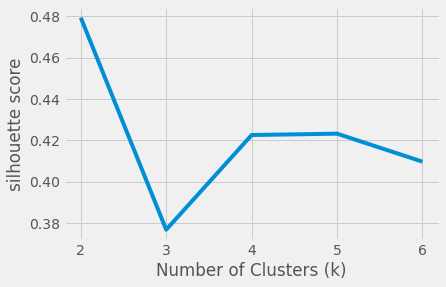

In [12]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
   
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

The silhouette score and the optimal K value you found is different

While the elbow technique and the silhouette score give data on distinct features, both are useful for clustering analysis.
Based on the details offered by the plots, the Elbow technique / SSE Plot and the Silhouette method can be utilised interchangeably.
It's possible that using both plots will ensure that you choose the most appropriate number of clusters.
While both give useful information for clustering analysis, the elbow approach is simpler to use and produces more useful findings. 
Look for the point when the SSE plot begins to look linear when utilising the elbow approach. In other words, at that time, there isn't much of a drop in SSE.
When utilising the Silhouette plot, check for the number of clusters with plots that are all above the average Silhouette score, have mainly consistent thickness, and do not have large size variations.
To ensure that you choose the most ideal number of clusters in K-means clustering, you might utilise both the SSE / Elbow plot and the Silhouette plot.

**Task 5) Visualize the k-means clusters and write your final observations of patterns you see.**

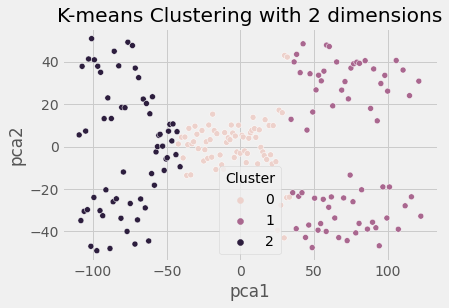

In [13]:

import seaborn as sns
from sklearn.decomposition import PCA
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=data['Cluster'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()


**Submission type: PDF file (convert the notebook to PDF and submit on canvas)**